<a href="https://colab.research.google.com/github/kei-kobayashi-3/ResNet/blob/main/Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets,models,transforms
from torch.utils.data import Dataset
import torch.optim as optim
from PIL import Image

In [ ]:
def get_model(target_num,ispretrained=False):
  
  if (ispretrained):
    model_ft=models.resnet18(pretrained=ispretrained)
    
  else:
    model_ft=models.resnet18(pretrained=False)

  model_ft.fc=nn.Linear(512,target_num)
  model_ft=model_ft.to(device)
  return model_ft

In [ ]:
# transforms

In [ ]:
data_transforms={
    'train':transforms.Compose([
                                transforms.Resize(256),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'val':transforms.Compose([
                              transforms.Resize(256),
                              transforms.ToTensor(),
                              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
}

In [ ]:
# dataset作成

In [ ]:
rm -rf `find -type d -name .ipynb_checkpoints`

In [ ]:
image_datasets={
    'train':datasets.ImageFolder('/content/drive/MyDrive/signate/鋳造/train',data_transforms['train']),
    'val':datasets.ImageFolder('/content/drive/MyDrive/signate/鋳造/val',data_transforms['val'])
}

In [ ]:
# dataloader作成

In [ ]:
image_dataloaders={
    'train':torch.utils.data.DataLoader(image_datasets['train'],batch_size=12,shuffle=True,num_workers=0,drop_last=True),
    'val':torch.utils.data.DataLoader(image_datasets['val'],batch_size=12,shuffle=False,num_workers=0,drop_last=True),
}

In [ ]:
# モデルのインスタンス作成

In [ ]:
device='cpu'
TARGET_NUM=2

In [ ]:
pretraind_model=get_model(target_num=TARGET_NUM,ispretrained=True)
pretraind_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
#　最適化関数定義

In [ ]:
optimizer=optim.SGD(pretraind_model.parameters(),lr=0.001,momentum=0.9)

In [ ]:
#　loss関数

In [ ]:
criterion=nn.CrossEntropyLoss()

In [ ]:
# モデル学習用関数

In [ ]:
def train_model(model,criterion,optimizer,num_epochs=10,is_saved=False):
  best_acc=0.0
  train_losses=[]
  val_losses=[]
  train_acces=[]
  val_acces=[]

  for epoch in range(num_epochs):
    for phase in ['train','val']:
      print('{}:エポック　　{}:フェイズ'.format(epoch+1,phase))

      if phase =='train':
        model.train()
      else:
        model.eval()

      running_loss=0.0
      running_corrects=0

      for i,(inputs,labels) in enumerate(image_dataloaders[phase]):
        inputs=inputs.to('cpu')
        labels=labels.to('cpu')

        optimizer.zero_grad()

        outputs=model(inputs)
        _,preds=torch.max(outputs,1)

        loss=criterion(outputs,labels)

        print('  loaders:{}回目'.format(i+1),'  loss:{}'.format(loss))

        if phase=='train':
          loss.backward()
          optimizer.step()

        running_loss += loss.item()*inputs.size(0)
        running_corrects += torch.sum(preds==labels.data)
     
      epoch_loss = running_loss / len(image_datasets[phase])
      epoch_acc = running_corrects.double() / len(image_datasets[phase])

      print('{} Loss: {:.4f}  Acc {:.4f}'.format(phase,epoch_loss,epoch_acc))
      if phase =='train':
        train_losses.append(epoch_loss)
        train_acces.append(epoch_acc)
      else:
        val_losses.append(epoch_loss)
        val_acces.append(epoch_acc)

      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        if (is_saved):
          torch.save(model.state_dict(),'/content/drive/MyDrive/signate/鋳造/original_model_{}.pth'.format(epoch))

  print('Best val acc: {:4f}'.format(best_acc))
  return train_losses,train_acces,val_losses,val_acces


In [ ]:
train_losses,train_acces,val_losses,val_acces=train_model(model=pretraind_model,optimizer=optimizer,is_saved=True,criterion=criterion)

1:エポック　　train:フェイズ
  loaders:1回目   loss:0.7161664962768555
  loaders:2回目   loss:0.7208883762359619
  loaders:3回目   loss:0.6120242476463318
  loaders:4回目   loss:0.6165388822555542
  loaders:5回目   loss:0.6139110922813416
  loaders:6回目   loss:0.47611236572265625
  loaders:7回目   loss:0.6040535569190979
  loaders:8回目   loss:0.6354876160621643
  loaders:9回目   loss:0.8244915008544922
  loaders:10回目   loss:0.47383490204811096
  loaders:11回目   loss:0.45113325119018555
  loaders:12回目   loss:0.38742056488990784
  loaders:13回目   loss:0.8272581696510315
  loaders:14回目   loss:0.2883605659008026
train Loss: 0.5822  Acc 0.6529
1:エポック　　val:フェイズ
  loaders:1回目   loss:0.7912220358848572
  loaders:2回目   loss:0.8882817625999451
  loaders:3回目   loss:0.8340652585029602
  loaders:4回目   loss:0.9408385753631592
  loaders:5回目   loss:0.3158441185951233
  loaders:6回目   loss:0.16604728996753693
val Loss: 0.5904  Acc 0.5125
2:エポック　　train:フェイズ
  loaders:1回目   loss:0.4976475238800049
  loaders:2回目   loss:0.241992101073

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
result=pd.DataFrame({'train_loss':train_losses,'train_acc':train_acces,'val_loss':val_losses,'val_acc':val_acces})

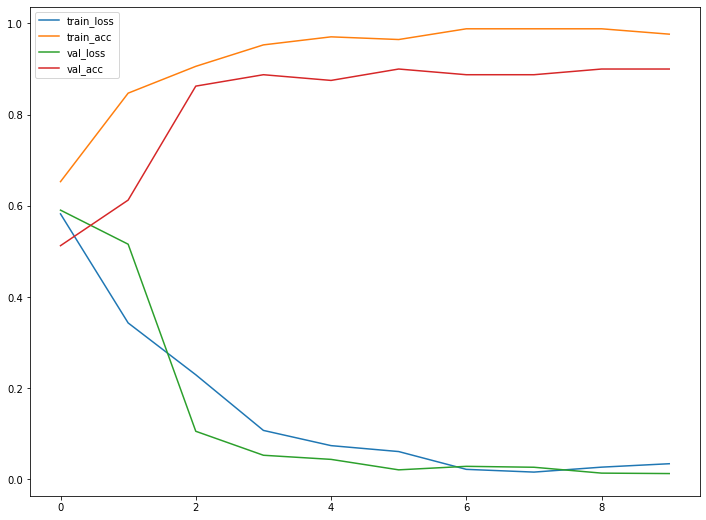

In [ ]:
fig,ax=plt.subplots(figsize=(12,9))
ax.plot(result['train_loss'],label='train_loss')
ax.plot(result['train_acc'],label='train_acc')
ax.plot(result['val_loss'],label='val_loss')
ax.plot(result['val_acc'],label='val_acc')
ax.legend()

In [ ]:
# 推論用のtransforrms

In [ ]:
test_transforms=transforms.Compose([
                                    transforms.Resize(256),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.484,0.456,0.406],[0.229,0.224,0.225]),
])

In [ ]:
class Test_Datasets(Dataset):

  def __init__(self,data_transform):
    self.df=pd.read_csv('/content/drive/MyDrive/signate/鋳造/test/df_test.csv')
    self.data_transform=data_transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self,index):
    file=self.df['filename'][index]
    image=Image.open('/content/drive/MyDrive/signate/鋳造/test/test_data/'+file)
    image=self.data_transform(image)

    return image,file

In [ ]:
# datasetのインスタンス作成

In [ ]:
test_dataset=Test_Datasets(data_transform=test_transforms)

In [ ]:
# dataloader作成

In [ ]:
test_dataloader=torch.utils.data.DataLoader(dataset=test_dataset,batch_size=1,shuffle=False,num_workers=0,drop_last=True)

In [ ]:
device='cpu'

In [ ]:
best_model=get_model(target_num=2,ispretrained=False)

In [ ]:
# 学習ずみモデルのロード

In [ ]:
best_model.load_state_dict(torch.load('/content/drive/MyDrive/signate/鋳造/original_model_5.pth',map_location=lambda strage, loc:strage),strict=True)

<All keys matched successfully>

In [ ]:
# 推論を行う

In [ ]:
df_test=pd.read_csv('/content/drive/MyDrive/signate/鋳造/test/df_test.csv')

In [ ]:
pred=[]

for i,(inputs,labels) in enumerate(test_dataloader):

  inputs=inputs.to(device)

  best_model.eval()

  outputs=best_model(inputs)

  _,preds=torch.max(outputs,1)

  pred.append(preds.item())

df_test['pred']=pred

In [ ]:
df_test

,filename,target,pred
0,789907.jpeg,0,1
1,439948.jpeg,0,1
2,489913.jpeg,0,1
3,429933.jpeg,0,0
4,499929.jpeg,0,0
...,...,...,...
95,899886.jpeg,0,1
96,889886.jpeg,0,0
97,309928.jpeg,0,0
98,839998.jpeg,0,1


In [ ]:
sample=pd.read_csv('/content/drive/MyDrive/signate/鋳造/sample_submission.csv')

In [ ]:
sample

,19871.jpeg,0
0,29934.jpeg,0
1,39826.jpeg,0
2,49888.jpeg,0
3,59918.jpeg,0
4,69975.jpeg,0
...,...,...
94,969983.jpeg,0
95,979891.jpeg,0
96,989921.jpeg,0
97,999921.jpeg,0


In [ ]:
df_test=df_test.drop(columns='target')

In [ ]:
df_test.to_csv('/content/drive/MyDrive/signate/鋳造/submit.csv',header=None,index=None)

In [ ]:
pd.read_csv('/content/drive/MyDrive/signate/鋳造/submit.csv')

,789907.jpeg,1
0,439948.jpeg,1
1,489913.jpeg,1
2,429933.jpeg,0
3,499929.jpeg,0
4,259831.jpeg,1
...,...,...
94,899886.jpeg,1
95,889886.jpeg,0
96,309928.jpeg,0
97,839998.jpeg,1
